In [1]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import warnings
from matplotlib.colors import PowerNorm

from plotting_tools import * 

In [2]:
memilio_pop = 8
rain_scenario = "Rain"
degradation_setting = "decay"

plot_path = f"../plots/correlations"
os.makedirs(plot_path, exist_ok=True)

In [3]:
df_wastewater = pd.read_csv(os.path.join("../..", "preprocessing/preprocessed_data/", f"pop{memilio_pop}", "substances", f"{degradation_setting}_{rain_scenario}_output_scaled_norm.csv"))

In [4]:
df_wastewater["time_in_hours"] = df_wastewater["time_in_minutes"]/60
df_wastewater = df_wastewater[df_wastewater["time_in_hours"].mod(1).fillna(1) == 0]
df_wastewater = df_wastewater[["time_in_hours", "time_in_days", "location", "simulation_id", "PMMoV_norm_covid"]]
df_wastewater.columns = ["time_in_hours", "time_in_days", "location", "memilio_id", "concentration"]

In [5]:
particle_details = pd.read_csv(f"../../raw_memilio_data/pop{memilio_pop}/pop{memilio_pop}_sel_particles.csv", sep=",", index_col=0)
particle_details.index.names = ["memilio_id"]

In [6]:
def load_prevalence_data(memilio_id): 
    df = pd.read_csv(f"../../raw_memilio_data/pop{memilio_pop}/shedding_output/{memilio_id}_output.csv", sep=" ", index_col=False)
    
    df = df.rename(columns={'Shedding': 'Transmission'})
    df["prevalence"] = df["E"] + df["Ins"] + df["Isy"] + df["Isev"] + df["Icri"]
    df["memilio_id"] = memilio_id
    
    df = df.merge(particle_details, on = "memilio_id", how = "left")
    df["Shedding"] = np.where(df["t"] <= df["damp_time"] * 24, df["Transmission"], df["Transmission"] / df["damp_lvl"]) # would need to divide by kappa_lambda and multiply by kappa_gamma to get magnitude of shedding levels

    return df[["t", "memilio_id", "prevalence", "Transmission", "Shedding"]]

df_prevalence = [load_prevalence_data(memilio_id) for memilio_id in range(1, 101)]
df_prevalence = pd.concat(df_prevalence)

In [7]:
def crosscorr(data_x, data_y, lag=0):
    return data_x.corr(data_y.shift(lag))

def get_vl_crosscorr_for_one_station(df_combined, location, lags_in_hours):
    df_combined_sub = df_combined.loc[df_combined.location==location, :].copy().sort_values("time_in_hours")
    return [crosscorr(df_combined_sub["concentration"], df_combined_sub["prevalence"], lag) for lag in lags_in_hours]

In [8]:
sampling_location = "Overall"
sim = 3

df_wastewater_1sim = df_wastewater.loc[df_wastewater['memilio_id'] == sim].copy()
df_prevalence_1sim = df_prevalence.loc[df_prevalence['memilio_id'] == sim].copy()
damp_time = pd.to_datetime(start_date) + pd.to_timedelta(particle_details.damp_time[sim], unit="day")

In [9]:
# Prepare results from selected simulation for plotting
def minmax(s):
    s = pd.Series(s).astype(float)
    rng = s.max() - s.min()
    if pd.isna(rng) or rng == 0:
        return pd.Series(0.0, index=s.index) 
    return (s - s.min()) / rng

to_plot = []

df_wastewater_sub = df_wastewater_1sim.loc[df_wastewater_1sim['location'] == sampling_location].copy().sort_values("time_in_hours")
df_wastewater_sub["Date"] = pd.to_datetime(start_date) + pd.to_timedelta(df_wastewater_sub["time_in_hours"], unit="hour")
temp = df_wastewater_sub[["Date", "concentration"]].dropna()
temp = temp.assign(series = f"Virus levels at {sampling_location} (PMMoV-normalized)", value = minmax(temp["concentration"]))
to_plot.append(temp[["Date", "series", "value"]])

df_prevalence_1sim["time_in_days"] = df_prevalence_1sim["t"] / 24
df_prevalence_1sim["Date"] = pd.to_datetime(start_date) + pd.to_timedelta(df_prevalence_1sim["t"], unit="hour")
temp = df_prevalence_1sim[["Date", "prevalence"]].dropna()
temp = temp.assign(series = "Infection prevalence", value = minmax(temp["prevalence"]))
to_plot.append(temp[["Date", "series", "value"]])

temp = df_prevalence_1sim[["Date", "Shedding"]].dropna()
temp = temp.assign(series="Summed RNA shedding rates", value=minmax(temp["Shedding"]))
to_plot.append(temp[["Date", "series", "value"]])

temp = df_prevalence_1sim[["Date", "Transmission"]].dropna()
temp = temp.assign(series="Summed transmission rates", value=minmax(temp["Transmission"]))
to_plot.append(temp[["Date", "series", "value"]])

to_plot = pd.concat(to_plot, ignore_index=True).sort_values("Date")


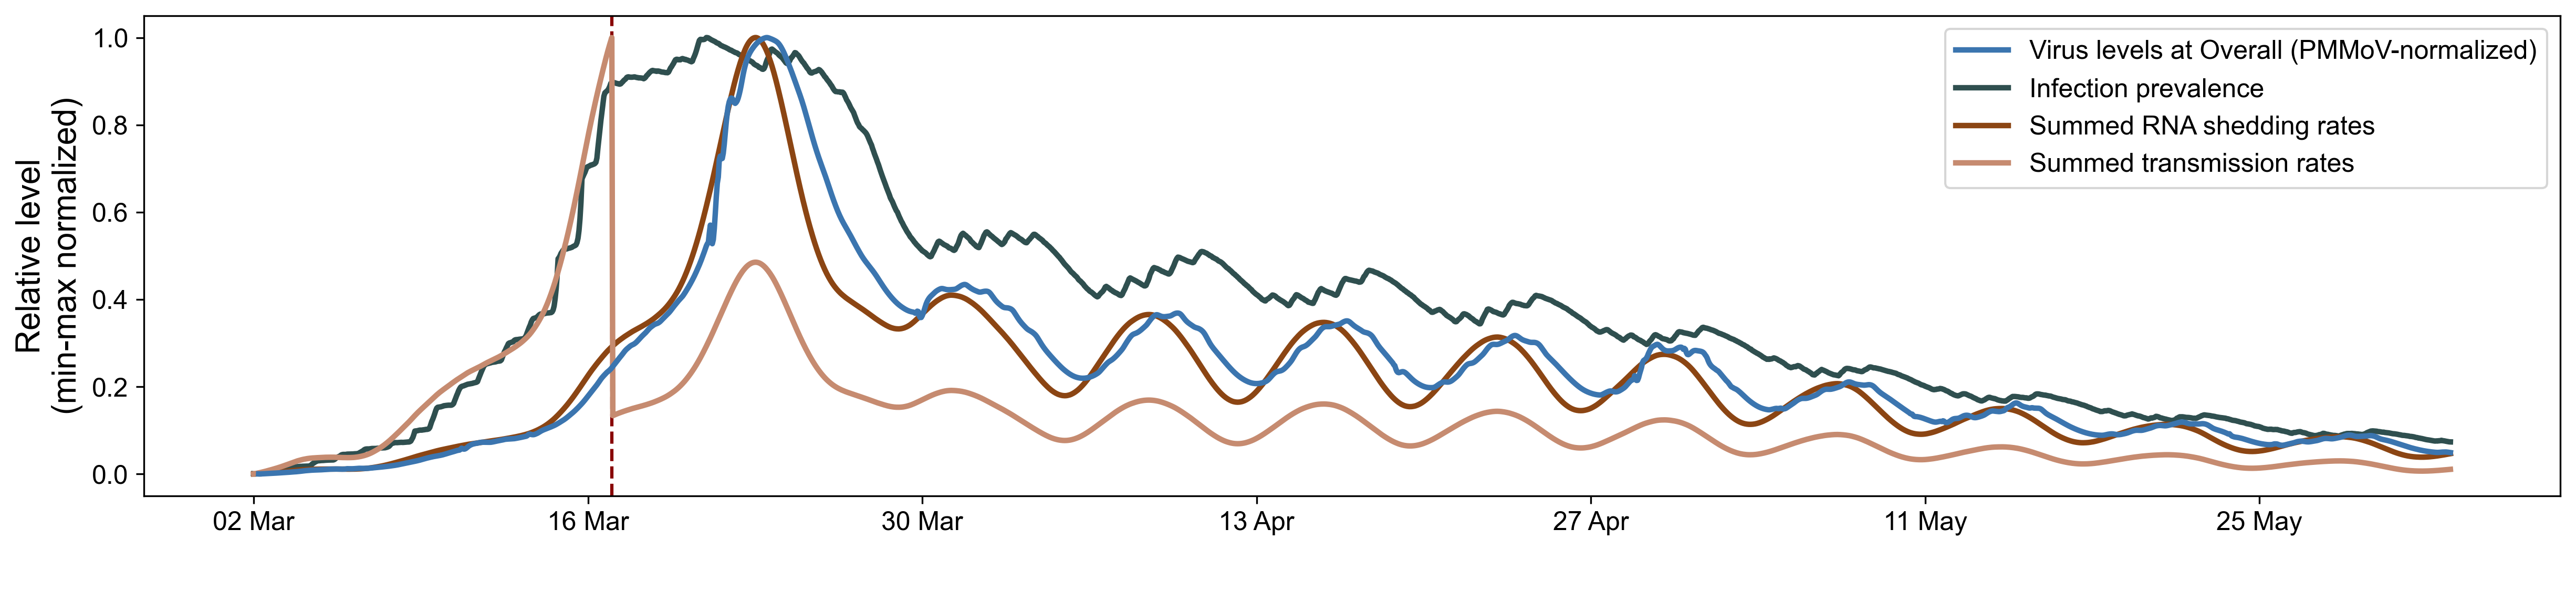

In [10]:
plt.style.use('default')
set_fontsize()

palette = {
    f"Virus levels at {sampling_location} (PMMoV-normalized)": '#3B75AF',
    "Summed RNA shedding rates": '#8B4513',
    "Summed transmission rates": '#C68B70',
    "Infection prevalence": '#2F4F4F',
}

fig, ax = plt.subplots(figsize = (16.6, 4), dpi=300)

plt.axvline(damp_time, 0, 1, color = "#880000", linestyle='--')

sns.lineplot(data=to_plot, x="Date", y="value", hue="series", ax=ax, palette=palette, linewidth=2.5, legend=True)
ax.set_ylabel("Relative level\n(min-max normalized)")
ax.set_xlabel(" ")
ax.set_xticks(pd.date_range(start=pd.Timestamp(start_date), end=to_plot["Date"].max(), freq="14D"))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))

ax.legend(loc="upper right", title="")
handles, labels = ax.get_legend_handles_labels()
label_order = [
    f"Virus levels at {sampling_location} (PMMoV-normalized)",
    "Infection prevalence",
    "Summed RNA shedding rates",
    "Summed transmission rates"
]
order_indices = [labels.index(l) for l in label_order]
ax.legend([handles[i] for i in order_indices],
          [labels[i] for i in order_indices],
          loc="upper right", title="")

# Adjust layout and save figure
plt.tight_layout()
fig.savefig(os.path.join(plot_path, f"trajectories_{sampling_location}_{rain_scenario}_{degradation_setting}_one_sim.png"), dpi=300)

In [12]:
warnings.filterwarnings("ignore", message="An input array is constant; the correlation coefficient is not defined.")
warnings.filterwarnings("ignore", message="invalid value encountered in divide")

max_lag_hours = 5 * 24

results = []
nas = []
for location in df_wastewater.loc[:,"location"].unique():
    
    loc_corr = []
    for sim_id in df_prevalence['memilio_id'].unique():
        curr_sim_ww = df_wastewater.loc[df_wastewater['memilio_id'] == sim_id].copy()
        curr_sim_prev = df_prevalence.loc[df_prevalence['memilio_id'] == sim_id].copy()
        curr_combined = curr_sim_ww.merge(curr_sim_prev, left_on="time_in_hours", right_on="t", how="left")
        loc_corr.append(get_vl_crosscorr_for_one_station(curr_combined, str(location), range(-max_lag_hours, max_lag_hours+1, 1)))
    
    df_corr = pd.DataFrame(loc_corr)
    results.append(df_corr.mean(axis = 0))
    nas.append(df_wastewater['memilio_id'].max() - sum(df_corr.transpose().isna().sum() > 0))
    print(location)

C_U
E_M
E_U
N_D
N_Ua
N_Ub
N_Uc
Overall
SCE_D1
SCE_D2
S_M1
S_M2
S_M3
S_M4
S_Ua
S_Ub


In [13]:
df_res = pd.DataFrame(results).transpose()
df_res.columns = df_wastewater.loc[:,"location"].unique()
df_res["lag_in_hours"] = range(-max_lag_hours, max_lag_hours + 1, 1)
df_res["lag_in_days"] = df_res["lag_in_hours"] / 24
df_res = df_res.set_index("lag_in_days")
df_res = df_res[["N_Ua", "N_Ub", "N_Uc", "C_U", "S_Ua", "S_Ub", "S_M1", "S_M2", "S_M3", "S_M4", "E_U", "E_M", "N_D", "SCE_D1", "SCE_D2", "Overall"]]

df_nas = pd.DataFrame(nas).transpose()
df_nas.columns = df_wastewater.loc[:,"location"].unique()
print(df_nas)

   C_U  E_M  E_U  N_D  N_Ua  N_Ub  N_Uc  Overall  SCE_D1  SCE_D2  S_M1  S_M2  \
0  100  100  100  100   100   100   100      100     100     100   100   100   

   S_M3  S_M4  S_Ua  S_Ub  
0   100   100   100   100  


In [14]:
warnings.filterwarnings("ignore", message="An input array is constant; the correlation coefficient is not defined.")
warnings.filterwarnings("ignore", message="invalid value encountered in divide")

results_corr_subset = []
for location in df_wastewater.loc[:,"location"].unique():

    loc_corr = []
    for sim_id in df_prevalence['memilio_id'].unique():
        min_time = (particle_details.damp_time[sim_id] + 5) * 24
        curr_sim_ww = df_wastewater.loc[((df_wastewater['memilio_id'] == sim_id) & (df_wastewater["time_in_hours"] >= min_time))].copy()
        curr_sim_prev = df_prevalence.loc[((df_prevalence['memilio_id'] == sim_id) & (df_prevalence["t"] >= min_time))].copy()
        curr_combined = curr_sim_ww.merge(curr_sim_prev, left_on="time_in_hours", right_on="t", how="left")
        loc_corr.append(get_vl_crosscorr_for_one_station(curr_combined, str(location), range(-max_lag_hours, max_lag_hours+1, 1)))

    df_corr = pd.DataFrame(loc_corr)
    results_corr_subset.append(df_corr.mean(axis = 0))
    print(location)

C_U
E_M
E_U
N_D
N_Ua
N_Ub
N_Uc
Overall
SCE_D1
SCE_D2
S_M1
S_M2
S_M3
S_M4
S_Ua
S_Ub


In [16]:
df_res_subset = pd.DataFrame(results_corr_subset).transpose()
df_res_subset.columns = df_wastewater.loc[:,"location"].unique()
df_res_subset["lag_in_hours"] = range(-max_lag_hours, max_lag_hours + 1, 1)
df_res_subset["lag_in_days"] = df_res_subset["lag_in_hours"] / 24
df_res_subset = df_res_subset.set_index("lag_in_days")
df_res_subset = df_res_subset[["N_Ua", "N_Ub", "N_Uc", "C_U", "S_Ua", "S_Ub", "S_M1", "S_M2", "S_M3", "S_M4", "E_U", "E_M", "N_D", "SCE_D1", "SCE_D2", "Overall"]]

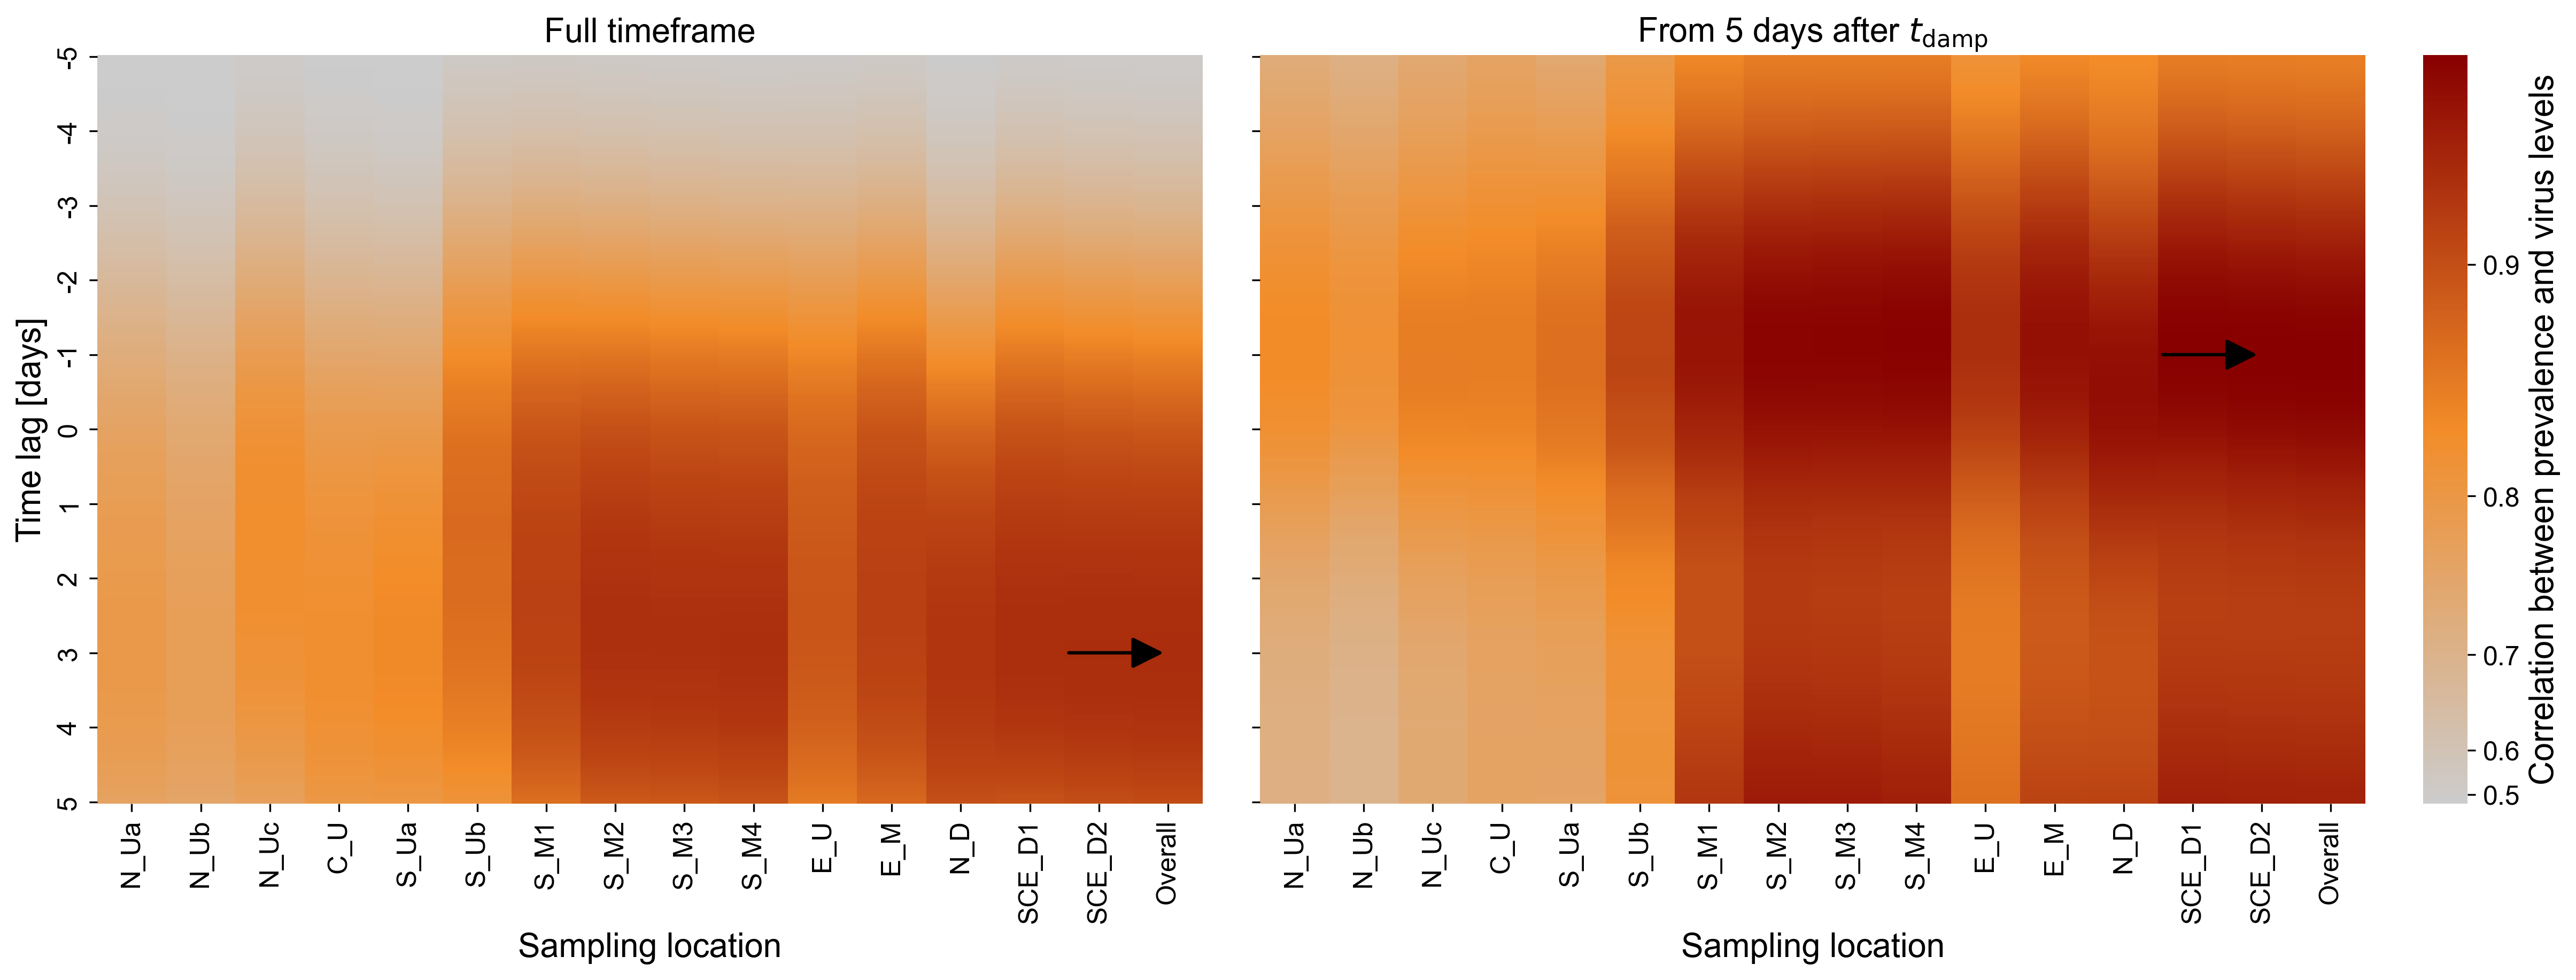

In [17]:
max_row1, max_col1 = np.unravel_index(df_res.values.argmax(), df_res.shape)
max_row2, max_col2 = np.unravel_index(df_res_subset.values.argmax(), df_res_subset.shape)

def add_arrow(ax, col, row, color='black'):
    ax.annotate('', xy=(col + 0.5, row + 0.5), xytext=(col - 1.0, row + 0.5), arrowprops=dict(arrowstyle='-|>,head_width=0.4,head_length=0.8', facecolor=color, edgecolor=color, lw=1.5))

plt.style.use('default')
set_fontsize()

custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ["#cccccc", "#F28C28", "#880000"])
vmin = min(df_res.min().min(), df_res_subset.min().min())
vmax = max(df_res.max().max(), df_res_subset.max().max())

gap = 0.04 
cbarw = 0.04 

norm = PowerNorm(gamma=2.5, vmin=vmin, vmax=vmax)

fig = plt.figure(figsize=(15.95, 6), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(1, 5, width_ratios=[1, gap, 1, gap, cbarw], wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 2])
cax = fig.add_subplot(gs[0, 4]) 

sns.heatmap(df_res, ax=ax1, cmap=custom_cmap, norm=norm, vmin=vmin, vmax=vmax, yticklabels=24, cbar=False)
ax1.set_xlabel("Sampling location")
ax1.set_ylabel("Time lag [days]")
ax1.set_title("Full timeframe")

sns.heatmap(df_res_subset, ax=ax2, cmap=custom_cmap, norm=norm, vmin=vmin, vmax=vmax, yticklabels=24, cbar=True, cbar_ax=cax)
ax2.set_xlabel("Sampling location")
ax2.set_title(r"From 5 days after $t_{\text{damp}}$")
ax2.set_ylabel("")
ax2.set_yticklabels([])
ax2.spines['left'].set_visible(False)

labels = [item.get_text() for item in ax1.get_yticklabels()]
ax1.set_yticklabels([str(int(float(label))) for label in labels])

cax.set_ylabel("Correlation between prevalence and virus levels")
desired_ticks = np.round(np.arange(0.5, 1.0, 0.1), 1)
cax.set_yticks(desired_ticks)
cax.set_yticklabels([str(t) for t in desired_ticks])

add_arrow(ax1, max_col1, max_row1, color='black')
add_arrow(ax2, max_col2, max_row2, color='black')

fig.savefig(os.path.join(plot_path, f"cross_correlation_{rain_scenario}_{degradation_setting}.png"), dpi=300)